# CHROMOSOME VALIDATION

In [5]:
!pip install numpy 



In [717]:
import numpy as np 
import pandas as pd
from math import log

def generate_dataset(
        num_stocks=500, start="2024-01-01", end="2024-01-31", freq="D"
    ):
        # Create a date range for all days in January
        date_range = pd.date_range(start=start, end=end, freq=freq)
        data = []
        for date in date_range:
            row = [date] + list(
                np.random.randint(100, 501, size=num_stocks)
            )
            data.append(row)
        columns = ["Date"] + [str(i) for i in range(1, num_stocks + 1)]
        df = pd.DataFrame(data, columns=columns)
        return df

# Approach inicial totalmente aleatorio, que no es factible   
def generate_chromosome(january,n_assets = 500, n_days = 31):
        valid = False
        while not valid :
            chromosome = np.random.randint(-10, 10, size=(n_assets, n_days))  # Cantidades aleatorias
            valid = check_chromosome(january,chromosome)
            print(chromosome,valid)
        return chromosome
    


def generate_chromosome_randomized_with_restrictions(january,n_assets=500, n_days=31, initial_capital=10000):
    valid = False
    while not valid:
        chromosome = np.zeros((n_assets, n_days), dtype=int)  # Initialize chromosome with 0
        total_capital = initial_capital  # Initial capital
        stocks_held = np.zeros(n_assets, dtype=int)  # Stocks held for each asset

        for day in range(n_days):
            # Generate a random order of assets to process
            random_asset_order = np.random.permutation(n_assets)

            for asset in random_asset_order:
                # Current asset price on the given day
                asset_price = january.iloc[day, asset]
                
                # Probability of each action (hold, buy, sell)
                action_prob = np.random.rand()

                # Hold action (33% probability)
                if action_prob < 1 / 3:
                    continue  # Do nothing
                # Buy action (33% probability)
                elif action_prob < 2 / 3:
                    if total_capital >= asset_price:  # Only buy if we have enough capital
                        max_buy = total_capital // asset_price  # Maximum we can buy
                        #max_buy = max(1, int(np.log(max_buy)))  # Ensure minimum of 1
                        
                        quantity = np.random.randint(1, max_buy + 1)  # Random buy quantity
                        chromosome[asset, day] = quantity  # Record buy action
                        stocks_held[asset] += quantity  # Update held stocks
                        total_capital -= quantity * asset_price  # Deduct capital
                # Sell action (33% probability)
                else:
                    if stocks_held[asset] > 0:  # Only sell if we own stocks
                        max_sell = stocks_held[asset]  # Cannot sell more than we own
                        quantity = np.random.randint(1, max_sell + 1)  # Random sell quantity
                        chromosome[asset, day] = -quantity  # Record sell action
                        stocks_held[asset] -= quantity  # Update held stocks
                        total_capital += quantity * asset_price  # Add capital from sale

        # Ensure all remaining stocks are sold on the last day
        for asset in range(n_assets):
            if stocks_held[asset] > 0:  # If there are remaining stocks
                last_day_price = january.iloc[n_days - 1, asset]  # Price on the last day
                
                chromosome[asset, n_days - 1] -= stocks_held[asset]  # Sell all remaining stocks
                #print(f"chromosome[asset, n_days - 1] : {chromosome[asset, n_days - 1]} = -stocks_held[asset] : {-stocks_held[asset]} ")
                total_capital += stocks_held[asset] * last_day_price  # Update total capital
                stocks_held[asset] = 0  # Clear remaining stocks

        # Validate the chromosome
        valid = check_chromosome(january, chromosome)  # Validate chromosome
        

    return chromosome



def check_all_stocks_sold(chromosome, end_date_index=30):
    """
    Checks if all stocks have been sold by the last day of the period.

    Parameters:
    - chromosome: numpy array with decisions to buy/sell/hold.
    - end_date_index: Column Index of the last day of the period (default is 30, cause there are 31 days in January).

    Returns:
    - bool: True if no stocks are left, False otherwise.
    """
    stocks_held = np.sum(chromosome[:, end_date_index], axis=0)
    all_sold = np.all(stocks_held == 0)
    
    return all_sold
   
    
def aux_check_chromosome_has_previous_stocks(chromosome) :
    for stock in range(chromosome.shape[0]):
        value = 0
        for day in range(chromosome.shape[1] -1 ): # -1 because we do not want to check the last day!
            value += chromosome[stock][day]
            if value < 0 : 
                #print(stock,day)
                return False
    return True

def check_chromosome(january,chromosome) :
    total = 10000
    day_sold = 0
    if np.any(chromosome[:, 0] < 0) : # Can´t sell in the first day 
        print("Can´t sell in the first day ")
        return False
    if not aux_check_chromosome_has_previous_stocks(chromosome) : # before selling stocks we must own them
        print("Before selling stocks we must own them")
        return False
    # if not check_all_stocks_sold(chromosome):
    #     print("All stocks must have been sold by the last day of the period.")
    #     return False
    
    for active_index in range(chromosome.shape[1]): # Iterate through columns(days)
        day_sold,day_spent = 0,0
       
        
        if np.any(chromosome[:, active_index] < 1): # If it decides to sell
            negative_indexes = np.where(chromosome[:, active_index] < 0)[0]
            for index in negative_indexes :
                day_sold +=  chromosome[index][active_index] * january.iloc[active_index, index ] # Date column is taken into account so +1
        total_before = total  
        total -= day_spent + day_sold 
        
        if np.any(chromosome[:, active_index] > 1): # If it decides to buy
            positive_indexes = np.where(chromosome[:, active_index] > 0)[0]
            for index in positive_indexes :
                day_spent +=  chromosome[index][active_index] * january.iloc[active_index, index ] # Date column is taken into account so +1
            
            if day_spent > total  : # Cannot spend more than you have. We first buy, then we can sell.
                print(f"Cannot spend more than you have.")
                return False
            
        if total < 0:  
            print(f"total<0 : {total} = {total_before} - {day_spent} + {day_sold}")  
            return False  
        # print(f"Day spent : {day_spent} > total : {total}")
        # print(f"TOTAL: {total},DAY_SOLD: {abs(day_sold)}, DAY_SPENT : {-day_spent}")
    return True

c = generate_chromosome_randomized_with_restrictions(generate_dataset().drop(columns=['Date']),n_assets=500)
# chromosome = np.array([
#     [0, 0, 5],
#     [-5, 0, 0],
#     [0, 15, -5],
#     [6, -5, 0],
#     [20, 0, 0]
# ]).T
# # Ejemplo simple de enero (31 días) para 3 activos
# january = pd.DataFrame({
#     1: [100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130],
#     2: [200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230],
#     3: [300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330]
# })
# print(chromosome)
# print(january.head(),january.shape)
# #january = pd.read_csv("data/data.csv")
# print(check_chromosome(january,chromosome))

In [657]:
poblation = [generate_chromosome_randomized_with_restrictions(generate_dataset().drop(columns=['Date']),n_assets=500) for i in range(100)]

# Multi-threading(en desarrollo)

In [ ]:
import numpy as np
from concurrent.futures import ProcessPoolExecutor
from math import log

def generate_single_chromosome(january, n_assets, n_days, initial_capital):
    valid = False
    i = 1
    while not valid:
        chromosome = np.zeros((n_assets, n_days), dtype=int)  # Inicializar cromosoma en 0
        total_capital = initial_capital  # Capital inicial
        stocks_held = np.zeros(n_assets, dtype=int)  # Número de acciones que poseemos por activo

        for day in range(n_days):
            for asset in range(n_assets):
                # Precio del activo actual en el día actual
                asset_price = january.iloc[day, asset]
                
                # Probabilidad de tomar cada acción (hold, buy, sell)
                action_prob = np.random.rand()

                # Acción de "holdear" (probabilidad 33%)
                if action_prob < 1/3:
                    chromosome[asset, day] = 0  # No hacer nada
                # Acción de "comprar" (probabilidad 33%)
                elif action_prob < 2/3:  
                    if total_capital >= asset_price:  # Solo comprar si tenemos suficiente capital
                        max_buy = total_capital // asset_price  # Máximo que podemos comprar
                    
                        max_buy = log(max_buy)
                        if max_buy <1 :
                            max_buy = 1
                        
                        quantity = np.random.randint(1, max_buy + 1)  # Comprar una cantidad aleatoria
                        chromosome[asset, day] = quantity  # Registrar compra
                        stocks_held[asset] += quantity  # Actualizar número de acciones
                        total_capital -= quantity * asset_price  # Descontar el capital usado
                # Acción de "vender" (probabilidad 33%)
                else:  
                    if stocks_held[asset] > 0:  # Solo vender si poseemos acciones de este activo
                        max_sell = stocks_held[asset]  # No podemos vender más de lo que tenemos
                        quantity = np.random.randint(1, max_sell + 1)  # Vender una cantidad aleatoria
                        chromosome[asset, day] = -quantity  # Registrar venta
                        stocks_held[asset] -= quantity  # Actualizar número de acciones restantes
                        total_capital += quantity * asset_price  # Aumentar el capital con la venta

            # Verificar que el capital no sea negativo al final del día
            if total_capital < 0:
                break  # Salir del bucle si el capital es negativo
            if i<1 :
                print(chromosome)
        # Validamos si el cromosoma es válido
            i+=1
        valid = check_chromosome(january, chromosome)  # Validar el cromosoma

    return chromosome

# def generate_chromosome(january, n_assets=500, n_days=31, initial_capital=10000, num_workers=8):
#     valid_chromosome = None

#     def check_and_return_chromosome(chromosome):
#         if check_chromosome(january, chromosome):
#             return chromosome
#         return None

#     with ProcessPoolExecutor(max_workers=num_workers) as executor:
#         while valid_chromosome is None:
#             # Crear cromosomas en paralelo
#             futures = [executor.submit(generate_single_chromosome, january, n_assets, n_days, initial_capital) for _ in range(num_workers)]
#             for future in futures:
#                 result = future.result()
#                 print(result)
#                 if check_and_return_chromosome(result):
#                     valid_chromosome = result
#                     break

#     return valid_chromosome


In [3]:
c = generate_chromosome_randomized_with_restrictions(generate_dataset().drop(columns=['Date']),n_assets=500)

In [4]:
c

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  0,  2, -2],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]])

In [718]:
def aux_check_chromosome_has_previous_stocks(chromosome) :
    for stock in range(chromosome.shape[0]):
        value = 0
        for day in range(chromosome.shape[1]-1):
            value += chromosome[stock][day]
            if value < 0 : 
                print(f"Stock: {stock}, day: {day}, value : {value}")
                return False
    return True

In [ ]:
c[6,30] = 0

In [5]:
aux_check_chromosome_has_previous_stocks(c)

True

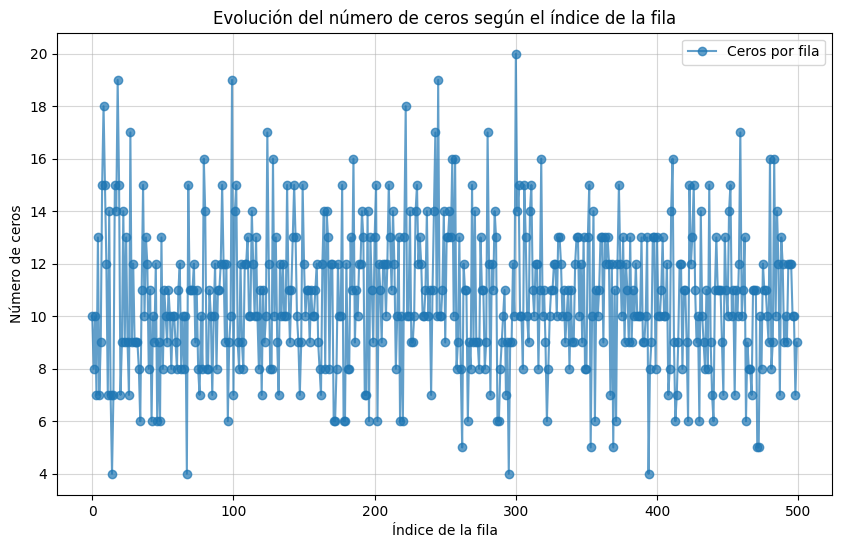

Correlación entre el índice de fila y el número de ceros: -0.01


In [7]:
import numpy as np
import matplotlib.pyplot as plt

def analyze_zero_increase(chromosome):
    """
    Analiza cómo cambia el número de ceros en las filas según aumenta el índice de las filas.
    """
    # Calcular el número de ceros por fila
    zeros_per_row = np.sum(chromosome == 0, axis=1)
    
    # Generar índice de fila
    row_indices = np.arange(len(zeros_per_row))
    
    # Visualización
    plt.figure(figsize=(10, 6))
    plt.plot(row_indices, zeros_per_row, marker='o', linestyle='-', alpha=0.7, label="Ceros por fila")
    plt.xlabel("Índice de la fila")
    plt.ylabel("Número de ceros")
    plt.title("Evolución del número de ceros según el índice de la fila")
    plt.grid(alpha=0.5)
    plt.legend()
    plt.show()
    
    # Calcular la correlación entre el índice de fila y el número de ceros
    correlation = np.corrcoef(row_indices, zeros_per_row)[0, 1]
    print(f"Correlación entre el índice de fila y el número de ceros: {correlation:.2f}")
    
    return zeros_per_row, correlation

# Ejemplo de uso
chromosome = np.random.randint(-1, 2, size=(500, 31))  # Generar un cromosoma aleatorio con -1, 0, 1
zeros_per_row, correlation = analyze_zero_increase(chromosome)


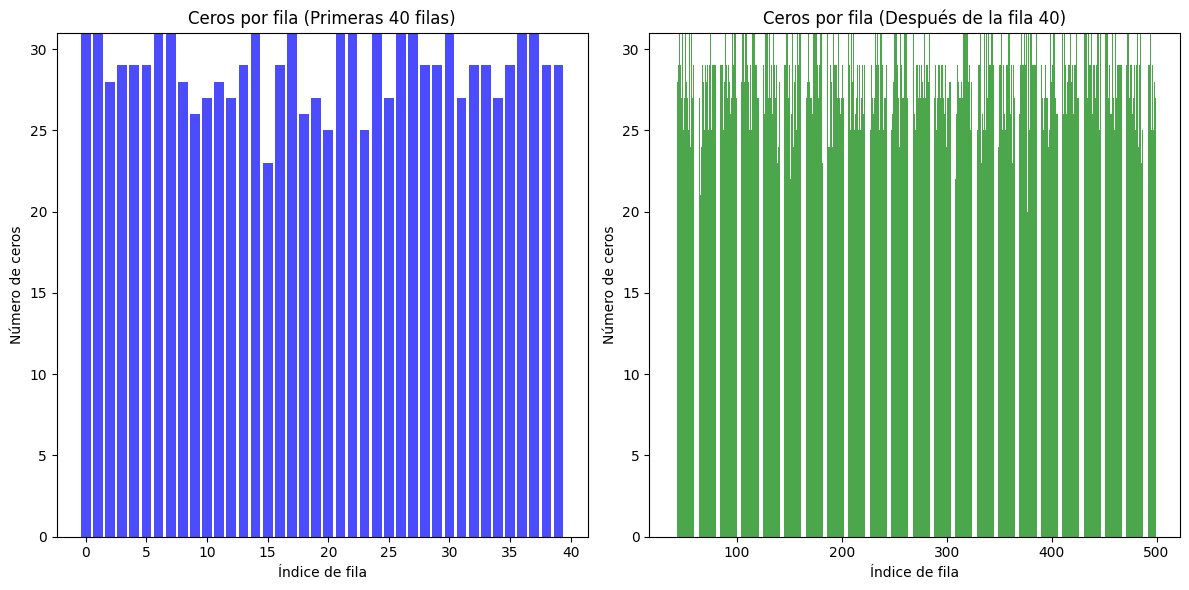

In [8]:
# Dividir el cromosoma en dos partes
f_40 = c[:40, :]  # Primeras 40 filas
after_40 = c[40:, :]  # Resto de las filas

# Calcular la cantidad de ceros en cada parte
zeros_per_row_f40 = np.sum(f_40 == 0, axis=1)
zeros_per_row_after40 = np.sum(after_40 == 0, axis=1)

# Crear el gráfico
plt.figure(figsize=(12, 6))

# Gráfico para las primeras 40 filas
plt.subplot(1, 2, 1)
plt.bar(range(40), zeros_per_row_f40, color='blue', alpha=0.7)
plt.title("Ceros por fila (Primeras 40 filas)")
plt.xlabel("Índice de fila")
plt.ylabel("Número de ceros")
plt.ylim(0, c.shape[1])  # Límite en y igual al número de columnas

# Gráfico para las filas después de la 40
plt.subplot(1, 2, 2)
plt.bar(range(40, c.shape[0]), zeros_per_row_after40, color='green', alpha=0.7)
plt.title("Ceros por fila (Después de la fila 40)")
plt.xlabel("Índice de fila")
plt.ylabel("Número de ceros")
plt.ylim(0, c.shape[1])  # Límite en y igual al número de columnas

plt.tight_layout()
plt.show()


# Recalculate capital

In [719]:
def get_capital(chromosome, january, asset_index, day_index, initial_capital=10000):
    """
    Calcula el capital restante y las acciones poseídas hasta un día y activo específicos.

    Parameters:
    - chromosome: np.ndarray, matriz de decisiones (compra/venta/holdear).
    - january: DataFrame, precios de los activos por día.
    - asset_index: int, índice del activo hasta el cual se evalúa.
    - day_index: int, índice del día hasta el cual se evalúa.
    - initial_capital: int, capital inicial disponible (por defecto, 10000).

    Returns:
    - capital: float, capital restante hasta el día y activo dados.
    - stocks_held: np.ndarray, acciones poseídas hasta el día y activo dados.
    """
    # Inicializar capital y stocks poseídos
    capital = initial_capital
    n_assets = chromosome.shape[0]
    stocks_held = np.zeros(n_assets, dtype=int)
    
    # Evaluar las decisiones hasta el día y activo seleccionados
    for d in range(day_index+1):  # Recorre días hasta el día dado
        for a in range(asset_index+1):  # Recorre activos hasta el índice dado
            if chromosome[a, d] > 0:  # Compra
                cost = chromosome[a, d] * january.iloc[d, a]
                capital -= cost
                stocks_held[a] += chromosome[a, d]
            elif chromosome[a, d] < 0:  # Venta
                revenue = -chromosome[a, d] * january.iloc[d, a]
                capital += revenue
                stocks_held[a] += chromosome[a, d]  # Resta la venta
    
    return capital, stocks_held


In [10]:
january = generate_dataset().drop(columns = ["Date"])
c = generate_chromosome_randomized_with_restrictions(january,n_assets=500)

In [ ]:
capital = get_capital(c,january,0,13)

# MUTATION

In [11]:
def swap_mutation(chromosome): # No es factible
    n_assets, n_days = chromosome.shape
    asset = np.random.randint(0, n_assets)  # Elegir un activo aleatorio
    day1, day2 = np.random.choice(n_days, 2, replace=False)  # Elegir dos días diferentes
    chromosome[asset, day1], chromosome[asset, day2] = chromosome[asset, day2], chromosome[asset, day1]
    return chromosome
import numpy as np

def mutate_chromosome(chromosome, january, initial_capital=10000, mutation_prob=0.1):
    """
    Realiza una mutación en el cromosoma respetando las restricciones usando `get_capital`.

    Parameters:
    - chromosome: np.ndarray, matriz de decisiones (compra/venta/holdear).
    - january: DataFrame, precios de los activos por día.
    - initial_capital: int, capital inicial disponible (por defecto, 10000).
    - mutation_prob: float, probabilidad de mutación para cada elemento del cromosoma.

    Returns:
    - mutated_chromosome: np.ndarray, cromosoma mutado.
    """
    mutated_chromosome = chromosome.copy()
    n_assets, n_days = chromosome.shape

    for day in range(n_days):
        for asset in range(n_assets):
            # Decidir si mutar este elemento
            if np.random.rand() < mutation_prob:
                # Obtener el capital y las acciones disponibles hasta este momento
                capital, stocks_held = get_capital(mutated_chromosome, january, asset_index=asset, day_index=day, initial_capital=initial_capital)

                # Precio del activo en el día actual
                asset_price = january.iloc[day, asset]

                # Decidir una nueva acción respetando las restricciones
                if capital >= asset_price:  # Comprar si hay suficiente capital
                    max_buy = capital // asset_price
                    max_buy = max(1, int(np.log(max_buy + 1)))  # Usar log para limitar compras grandes
                    new_value = np.random.randint(1, max_buy + 1)  # Nueva cantidad a comprar
                elif stocks_held[asset] > 0:  # Vender si hay acciones disponibles
                    max_sell = stocks_held[asset]
                    new_value = -np.random.randint(1, max_sell + 1)  # Nueva cantidad a vender
                else:  # Hold si no se puede comprar ni vender
                    new_value = 0

                # Actualizar el cromosoma con la nueva decisión
                mutated_chromosome[asset, day] = new_value

    return mutated_chromosome

def mutate_selected_points(chromosome, january, selected_indices, initial_capital=10000):
    """
    Realiza mutaciones en puntos seleccionados de un cromosoma respetando las restricciones.

    Parameters:
    - chromosome: np.ndarray, matriz de decisiones (compra/venta/holdear).
    - january: DataFrame, precios de los activos por día.
    - selected_indices: list of tuples, lista de índices (stock, día) a mutar.
    - initial_capital: int, capital inicial disponible (por defecto, 10000).

    Returns:
    - mutated_chromosome: np.ndarray, cromosoma mutado.
    """
    mutated_chromosome = chromosome.copy()
    n_assets, n_days = chromosome.shape

    for asset_index, day_index in selected_indices:
        # Obtener el capital y las acciones disponibles hasta este momento
        capital, stocks_held = get_capital(mutated_chromosome, january, asset_index, day_index, initial_capital)

        # Precio del activo en el día actual
        asset_price = january.iloc[day_index, asset_index]

        # Decidir una nueva acción respetando las restricciones
        if capital >= asset_price:  # Comprar si hay suficiente capital
            max_buy = capital // asset_price
            max_buy = max(1, int(np.log(max_buy + 1)))  # Usar log para limitar compras grandes
            new_value = np.random.randint(1, max_buy + 1)  # Nueva cantidad a comprar
        elif stocks_held[asset_index] > 0:  # Vender si hay acciones disponibles
            max_sell = stocks_held[asset_index]
            new_value = -np.random.randint(1, max_sell + 1)  # Nueva cantidad a vender
        else:  # Hold si no se puede comprar ni vender
            new_value = 0

        # Actualizar el cromosoma con la nueva decisión
        mutated_chromosome[asset_index, day_index] = new_value

    return mutated_chromosome


def mutate_selected_points(chromosome, january, initial_capital=10000):
    """
    Realiza mutaciones en puntos seleccionados de un cromosoma respetando las restricciones.

    Parameters:
    - chromosome: np.ndarray, matriz de decisiones (compra/venta/holdear).
    - january: DataFrame, precios de los activos por día.
    - initial_capital: int, capital inicial disponible (por defecto, 10000).

    Returns:
    - mutated_chromosome: np.ndarray, cromosoma mutado.
    """
    mutated_chromosome = chromosome.copy()
    n_assets, n_days = chromosome.shape
    # day_index = escoger aleatoriamente un dia entre 0,30
    # asset_index = escoger aleatoriamente un dia entre 0,499
    capital = get_capital(chromosome, january,asset_index,day_index)
    # reconfigura la forma en la que se ha gastado el dinero hasta el punto seleccionado siguiendo las restricciones de alguna forma


In [733]:
import pandas as pd
import numpy as np

def filter_and_choose_random(january, last_day, asset, max_quantity):
    """
    Filtra el DataFrame `january` para seleccionar valores mayores a un día y activo dados,
    y con precios menores que una cantidad específica. Finalmente, escoge uno al azar.

    Parameters:
    - january: pd.DataFrame, precios de los activos (filas: días, columnas: activos).
    - last_day: int, índice del último día considerado.
    - asset: int, índice del activo.
    - max_quantity: float, cantidad máxima para filtrar.

    Returns:
    - (selected_day, selected_asset, price): Tupla con el día, activo y precio seleccionado.
      Devuelve (None, None, None) si no hay resultados que cumplan las condiciones.
    """
    # Filtrar el DataFrame para días y activos posteriores al dado
    filtered_df = january.iloc[last_day:-1, asset]
    
    # Filtrar valores por la cantidad máxima
    filtered_df = filtered_df[filtered_df <= max_quantity]
    
    # Verificar si hay elementos disponibles después del filtrado
    if filtered_df.empty:
        return None, None, None

    # Escoger un índice aleatorio entre los valores que cumplen las condiciones
    selected_index = np.random.choice(filtered_df.index)

    # Devolver el día, el activo y el precio
    return selected_index, asset, january.iloc[selected_index, asset]

def find_lasts_movements(chromosome, day_index, asset_index):
    """
    Encuentra la última y próxima compra y venta realizada en cualquier activo antes de un día específico.

    Parameters:
    - chromosome: np.ndarray, matriz de decisiones (compra/venta/holdear).
    - day_index: int, índice del día.
    - asset_index int, índice del stock.

    Returns:
    - 
    """
    results = list()
    asset_found = False
    day_found = False
    # Recorrer días y activos en orden inverso
    for asset in range(asset_index - 1, -1, -1):
        for day in range(day_index- 1, -1, -1):
            if chromosome[asset, day] > 0:  # Si se encuentra una compra
                last_buy = [asset,day,chromosome[asset, day]]
                results.append(last_buy)
                asset_found = True
                break
        if not asset_found :
            return []
        else : 
            break
            

    # Recorrer días y activos en orden lógico
    for day_ind in range(day + 1, chromosome.shape[1],1):
            if chromosome[asset, day_ind] < 0:  # Si se encuentra una venta
                results.append([asset,day_ind,chromosome[asset, day_ind]])
                day_found = True
                break
                
            if not day_found :
                return []

    return results

def generate_mutation_indices(chromosome, num_mutations):
    """
    Genera índices de mutación asegurando que siempre cumplan con los criterios
    de encontrar una última compra válida y una venta válida.

    Parameters:
    - chromosome: np.ndarray, matriz de decisiones (compra/venta/holdear).
    - num_mutations: int, número de mutaciones a generar.

    Returns:
    - list de tuplas (asset_index, day_index) con índices válidos.
    """
    n_assets, n_days = chromosome.shape
    selected_indices = []

    while len(selected_indices) < num_mutations:
        # Generar índices aleatorios
        asset_index = np.random.randint(0, n_assets)
        day_index = np.random.randint(0, n_days)

        try :
            # Comprobar si el índice cumple con los criterios
            movements = find_lasts_movements(chromosome, day_index, asset_index)
            # Validar si encontró tanto una compra como una venta
            last_buy = any(m[2] > 0 for m in movements)
            next_sale = any(m[2] < 0 for m in movements)

            if last_buy and next_sale:
                selected_indices.append((asset_index, day_index))
        except :
            continue



    return selected_indices


def mutate_selected_points(chromosome, january, initial_capital=10000,num_mutations = 1):
    """
    Realiza mutaciones en puntos seleccionados de un cromosoma respetando las restricciones.

    Parameters:
    - chromosome: np.ndarray, matriz de decisiones (compra/venta/holdear).
    - january: DataFrame, precios de los activos por día.
    - initial_capital: int, capital inicial disponible (por defecto, 10000).

    Returns:
    - mutated_chromosome: np.ndarray, cromosoma mutado.
    """
    mutated_chromosome = chromosome.copy()
    n_assets, n_days = chromosome.shape
    selected_indices = generate_mutation_indices(chromosome, num_mutations=num_mutations)#[(np.random.randint(0, n_assets), np.random.randint(0, n_days)) for _ in range(num_mutations)]
    print(selected_indices)
    
    for asset_index, day_index in selected_indices:
        # Obtener el capital y las acciones disponibles hasta este momento
        capital, stocks_held = get_capital(mutated_chromosome, january, asset_index, day_index, initial_capital)

        # Precio del activo en el día actual
        asset_price = january.iloc[day_index, asset_index]
        
        movements = find_lasts_movements(chromosome, day_index, asset_index)
        last_asset, last_day, quantity =  movements[0] # Buys
        print(f"Buys : {movements[0]}")
        print(f"Sells : {movements[1]}")
        substract = np.random.randint(1, quantity+1)
        mutated_chromosome[last_asset][last_day] = quantity - substract # Now we must make sure we sell "substract amount" fewer participations of that stock!
        
        last_sell, last_sell_day, sell_quantity = movements[1] # Sells
        mutated_chromosome[last_sell][last_sell_day] = sell_quantity + substract # now we should have substract*january.iloc[last_day, last_asset] USD more

        extra_usd_earned = substract*january.iloc[last_day, last_asset]
        
        selected_day, selected_asset, price = filter_and_choose_random(january, last_day, last_asset, extra_usd_earned)
        max_buy = extra_usd_earned // price
        actives_bought = np.random.randint(1, max_buy + 1) # we should have some USD margin. We must now make sure to sell them before january ends.
        mutated_chromosome[selected_asset][selected_day] = actives_bought
        
        day_to_sell = np.random.choice([day for day in range(selected_day,30,1)]) # We select a random day to sell, but not the last one.
        mutated_chromosome[selected_asset][day_to_sell] -= actives_bought
        
        
    return mutated_chromosome


c_muted = mutate_selected_points(c,january)
print(check_chromosome(january,chromosome=c_muted))


[(495, 28)]
Buys : [494, 25, 6]
Sells : [494, 26, -2]
True


In [120]:
print(check_chromosome(january,chromosome=c_muted))

True


# Objective function : CARA